# Introduction

In ecommerce companies like online retails, customer segmentation is necessary in order to understand customers behaviors. It leverages aqcuired customer data like the one we have in our case, **transactions data** in order to divide customers into groups. 

Our goal in this Notebook is to cluster our customers to get insights in:
- Increasing **revenue** (Knowing customers who present most of our revenue)
- Increasing customer **retention**
- Discovering **Trends and patterns** 
- Defining **customers at risk**

We will do **RFM Analysis** as a first step and then **combine RFM with predictive algorithms (k-means)**. 

RFM Analysis answers these questions:
- Who are our best customers?
- Who has the potential to be converted in more profitable customers?
- Which customers we must retain?
- Which group of customers is most likely to respond to our current campaign?

In [1]:
import sys
sys.path.append('/anaconda3/envs/virtual/lib/python3.6/site-packages')
import pandas as pd
import numpy as np
import plotly.plotly as py
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns 
import warnings

In [2]:
retail=pd.read_excel('Online Retail.xlsx') 

In [3]:
data=retail 

In [4]:
#data.head(10)
#data.describe() 
#%timeit data.isnull().sum()
#data.columns

In [5]:
#check the number of NaN values in each col in the dataset (after you convert "missing values" to NaN)
data.isnull().sum() 
data[data['Description'] == '?'] 
?pd.DataFrame.dropna()
#drop only if na is in a specific column 
new_data=data.dropna(subset=['CustomerID']) #subset=[], put colname directly in [], no need to add data[]

In [6]:
#make the date range a full year
new_data['InvoiceDate'].describe()
new_data=new_data[new_data['InvoiceDate']>='2010-12-09']

In [7]:
new_data['InvoiceDate'].describe()
new_data['Country'].describe() 
new_data.Country.unique() 
new_data=new_data[new_data['Country']=='United Kingdom']

In [8]:
#len(new_data.InvoiceNo.unique())

In [9]:
#len(new_data.CustomerID.unique())

In [10]:
len(new_data.InvoiceNo) #349806
len(str(new_data.InvoiceNo)) #1083
str(new_data.InvoiceNo)
#convert col datatype by using apply
new_data.CustomerID=new_data.CustomerID.apply(int)

In [11]:
new_data.InvoiceNo=new_data.InvoiceNo.apply(str)

In [12]:
new_data['Return']= ['C' in i for i in new_data.InvoiceNo]

In [13]:
new_data['Return'].head(10)
new_data['Return']=new_data['Return'].apply(str)

In [14]:
new_data['Purchase']=np.where(new_data['Return']=='True',0,1) 
new_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Return,Purchase
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243,United Kingdom,False,1
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243,United Kingdom,False,1
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243,United Kingdom,False,1
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243,United Kingdom,False,1
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243,United Kingdom,False,1


In [15]:
#create customer-level data
customers=pd.DataFrame(new_data.CustomerID.unique())

In [16]:
customers.columns=['CustomerID'] 

In [17]:
#Recency
new_data['InvoiceDate2']= pd.to_datetime(new_data['InvoiceDate']) #no coerce

In [18]:
#here when you get difference between two to_datetime, the new col will be timedelta format
new_data['Recency']=pd.to_datetime('2011-12-10')-new_data['InvoiceDate2']

In [19]:
#delete row based on some col values
new_data=new_data[new_data.Purchase!=0]

In [20]:
recency=new_data.groupby('CustomerID')['Recency'].min() 

In [21]:
recency=pd.DataFrame(recency)
recency=recency.reset_index()

In [22]:
customers=customers.merge(recency, on='CustomerID')

In [23]:
#for timedelta format, you need to use .days() to extract days
customers.Recency=customers.Recency.dt.days  #pd.Series.dt.days: number of days for each element

In [24]:
new_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Return,Purchase,InvoiceDate2,Recency
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243,United Kingdom,False,1,2010-12-09 08:34:00,365 days 15:26:00
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243,United Kingdom,False,1,2010-12-09 08:34:00,365 days 15:26:00
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243,United Kingdom,False,1,2010-12-09 08:34:00,365 days 15:26:00
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243,United Kingdom,False,1,2010-12-09 08:34:00,365 days 15:26:00
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243,United Kingdom,False,1,2010-12-09 08:34:00,365 days 15:26:00


In [25]:
#frequency
customer_invoices=pd.DataFrame(new_data[['CustomerID','InvoiceNo','Purchase']])
customer_invoices.head()

,CustomerID,InvoiceNo,Purchase
19632,14243,537879,1
19633,14243,537879,1
19634,14243,537879,1
19635,14243,537879,1
19636,14243,537879,1


In [26]:
customer_invoices=customer_invoices.drop_duplicates()
customer_invoices.head()

,CustomerID,InvoiceNo,Purchase
19632,14243,537879,1
19640,12963,537880,1
19656,15513,537881,1
19668,15079,537882,1
19672,14437,537883,1


In [27]:
customer_invoices=customer_invoices.sort_values('CustomerID')
customer_invoices.head()

,CustomerID,InvoiceNo,Purchase
61619,12346,541431,1
241991,12747,558265,1
64849,12747,541677,1
175871,12747,551992,1
308314,12747,563949,1


In [28]:
invoices=pd.DataFrame(customer_invoices.groupby('CustomerID')['Purchase'].sum())

In [29]:
invoices=invoices.reset_index()

In [30]:
invoices.head()

,CustomerID,Purchase
0,12346,1
1,12747,10
2,12748,196
3,12749,5
4,12820,4


In [31]:
invoices.columns.values[1]='Frequency'

In [32]:
invoices.head()

,CustomerID,Frequency
0,12346,1
1,12747,10
2,12748,196
3,12749,5
4,12820,4


In [33]:
customers.head() 

,CustomerID,Recency
0,14243,8
1,12963,8
2,15513,33
3,15079,212
4,14437,365


In [34]:
invoices.columns=invoices.columns.str.strip()

In [35]:
invoices.Frequency
customers=customers.merge(invoices, on='CustomerID',sort=True)

In [36]:
customers=customers[customers.Frequency>0]

In [37]:
#monetary values of purchase
new_data.head()
new_data['Amount']=new_data['Quantity']*new_data['UnitPrice']

In [38]:
new_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Return,Purchase,InvoiceDate2,Recency,Amount
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243,United Kingdom,False,1,2010-12-09 08:34:00,365 days 15:26:00,47.4
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243,United Kingdom,False,1,2010-12-09 08:34:00,365 days 15:26:00,37.2
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243,United Kingdom,False,1,2010-12-09 08:34:00,365 days 15:26:00,15.3
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243,United Kingdom,False,1,2010-12-09 08:34:00,365 days 15:26:00,31.8
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243,United Kingdom,False,1,2010-12-09 08:34:00,365 days 15:26:00,15.9


In [39]:
#to plot year vs quantity 
import time
from datetime import datetime
date=pd.Series([val.date() for val in new_data.InvoiceDate])

In [40]:
quant=new_data['Quantity']

In [41]:
date=date.rename('Date')

In [42]:
#print(pd.concat([date,quant],axis=1)) indexes are different 
#print(len(date)) 
#print(len(quant))
#print(type(quant))
#print(date.head())
#print(quant.head())

In [43]:
quant=pd.DataFrame(quant)  #transfer series to dataframe first and then do reset_index

In [44]:
quant=quant.reset_index()

In [45]:
quant.head()
quant.drop('index',axis=1, inplace=True)

In [46]:
quant.head()
quant_change=pd.concat([date,quant],axis=1)

In [47]:
new_quant=pd.DataFrame(quant_change.groupby('Date')['Quantity'].sum())

In [48]:
new_quant.head()
new_quant=new_quant.reset_index()

In [49]:
new_quant.head()
new_quant.Date=new_quant.Date.apply(str)
#type(new_quant.Date[0])

In [50]:
#maybe change to month...
new_quant.Date.head()
new_quant.Date=new_quant.Date.str[:-3]

In [51]:
new_quant.Date.head()
new_quant=new_quant.groupby('Date')['Quantity'].sum()

In [52]:
new_quant=pd.DataFrame(new_quant)

In [53]:
new_quant.head()
new_quant=new_quant.reset_index()

In [54]:
new_quant.head()

,Date,Quantity
0,2010-12,141498
1,2011-01,278300
2,2011-02,213391
3,2011-03,276345
4,2011-04,260450


In [55]:
plt.figure(figsize=(11,8))
plt.scatter(new_quant.Date, new_quant.Quantity)  #the qualitative data should be string format, not other any format
plt.title('Quantity Trend Over Months',fontsize=16)
plt.xlabel('Year-Month',fontsize=16)
plt.ylabel('Quantity',fontsize=16)

Text(0,0.5,'Quantity')

In [56]:
#for amount
new_date2=new_data.InvoiceDate.apply(str)

In [57]:
amount=pd.DataFrame(new_data.Amount)

In [58]:
amount=amount.reset_index()
amount.drop('index',axis=1,inplace=True)

In [59]:
new_amt=pd.concat([date,amount],axis=1)
new_amt.head()
new_amt.Date=new_amt.Date.apply(str)

In [60]:
new_amt.Date=new_amt.Date.str[:-3]

In [61]:
new_amt=pd.DataFrame(new_amt.groupby('Date')['Amount'].sum())

In [62]:
new_amt.head()
new_amt=new_amt.reset_index()
##the qualitative data in the plot should be string format, not other any format

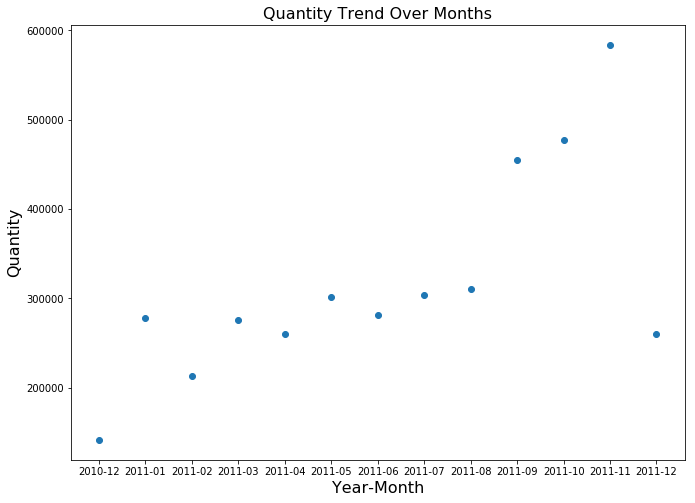

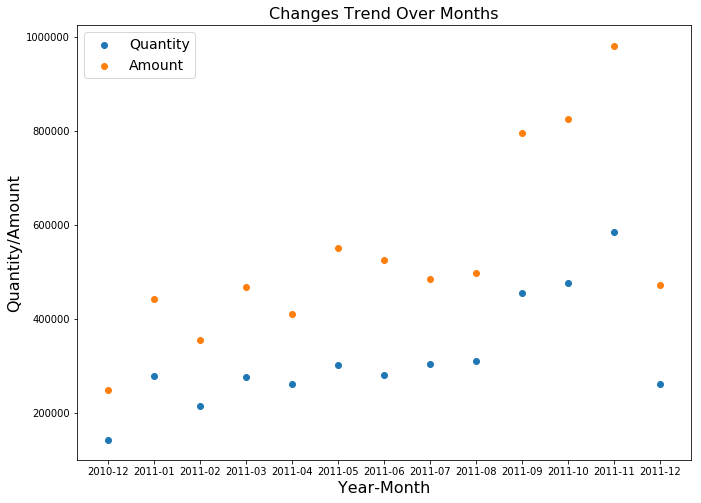

In [63]:
plt.figure(figsize=(11,8))
line1=plt.scatter(new_quant.Date, new_quant.Quantity)  
line2=plt.scatter(new_amt.Date, new_amt.Amount)
plt.legend((line1,line2),('Quantity','Amount'),fontsize=14)
plt.title('Changes Trend Over Months',fontsize=16)
plt.xlabel('Year-Month',fontsize=16)
plt.ylabel('Quantity/Amount',fontsize=16)
plt.show()

In [64]:
monetary=pd.DataFrame(new_data.groupby('CustomerID')['Amount'].sum())

In [65]:
monetary=monetary.reset_index()  

In [66]:
customers=customers.merge(monetary,on='CustomerID')

In [67]:
customers.columns.values[3]='Monetary'

In [68]:
customers.columns=customers.columns.str.strip()

In [69]:
customers['Monetary']=np.where(customers['Monetary']<0, 0, customers['Monetary'])

In [70]:
#80/20 rule: 80%sales may come from only 20% customers
#These 20% represent the high-value, important customers a business would want to protect.
#it doesn't have to be 20%
#pd.DataFrame.sort_values

In [71]:
customers=customers.sort_values('Monetary', ascending=False)


In [72]:
cutoff=0.8*customers.Monetary.sum()

In [73]:
customers['Pareto']=np.where(np.cumsum(customers.Monetary)<=cutoff, 'Top 20%', 'Bottom 80%')

In [74]:
#count the number of True in a col 
np.sum(customers.Pareto=='Top 20%')  

1069

In [75]:
1069/len(customers.Pareto) #27.67% are customers we need to focus on

0.2767279316593321

In [76]:
customers=customers.sort_values('CustomerID')

In [77]:
#top20% custoemrs
customer_top20=customers[customers.Pareto=='Top 20%']
customer_top20.head()

,CustomerID,Recency,Frequency,Monetary,Pareto
0,12346,325,1,77183.60,Top 20%
1,12747,2,10,3837.45,Top 20%
2,12748,0,196,31854.58,Top 20%
3,12749,3,5,4090.88,Top 20%
7,12823,74,5,1759.50,Top 20%


In [78]:

customers.head()
customers['RecencyLog']=np.where(customers.Recency==0,0.001,np.log(customers.Recency))


/Users/shwetatatiya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log



In [79]:
customers['FrequencyLog']=np.where(customers.Frequency==0,0.001,np.log(customers.Frequency))
customers['MonetaryLog']=np.where(customers.Monetary==0,0.001,np.log(customers.Monetary))

/Users/shwetatatiya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in log



In [80]:
customers.head()
customers['RecencyScale']=preprocessing.scale(customers['RecencyLog'])

In [81]:
customers['FrequencyScale']=preprocessing.scale(customers['FrequencyLog'])
customers['MonetaryScale']=preprocessing.scale(customers['MonetaryLog'])

In [82]:
customers.head()

,CustomerID,Recency,Frequency,Monetary,Pareto,RecencyLog,FrequencyLog,MonetaryLog,RecencyScale,FrequencyScale,MonetaryScale
0,12346,325,1,77183.60,Top 20%,5.783825,0.000000,11.253942,1.425140,-1.042054,3.795425
1,12747,2,10,3837.45,Top 20%,0.693147,2.302585,8.252563,-2.057858,1.537518,1.383611
2,12748,0,196,31854.58,Top 20%,0.001000,5.278115,10.368936,-2.531419,4.870985,3.084262
3,12749,3,5,4090.88,Top 20%,1.098612,1.609438,8.316515,-1.780442,0.760989,1.435001
4,12820,3,4,942.34,Bottom 80%,1.098612,1.386294,6.848366,-1.780442,0.511003,0.255243


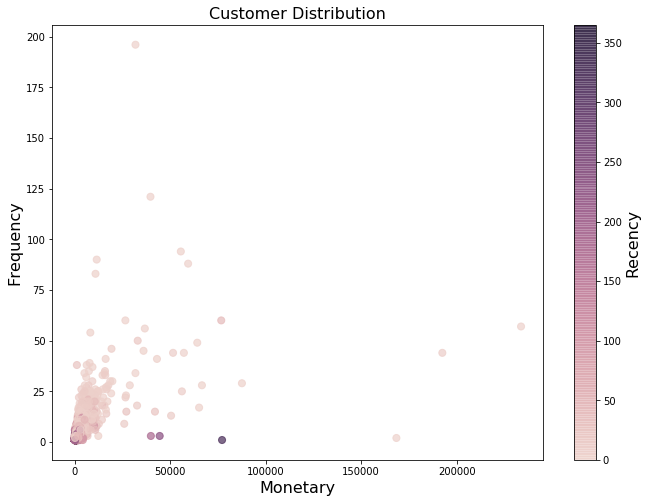

In [83]:
#visaulize the data
fig=plt.figure(figsize=(11, 8))
cmap = sns.cubehelix_palette(as_cmap=True)
ax = fig.add_subplot(111)

#for i in range(len(customers.Pareto)):
#plt.scatter(xs[i], ys[i], marker=m[i])
points=ax.scatter(customers.Monetary, customers.Frequency, c=customers.Recency,s=50, cmap=cmap, alpha=0.7)
   

ax.set_xlabel('Monetary', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.set_title('Customer Distribution', fontsize=16)

cbar=fig.colorbar(points)
#cbar.ax.set_yticklabels('Recency')  #change the scale of colorbar
cbar.ax.set_ylabel('Recency', fontsize=16)
plt.show()

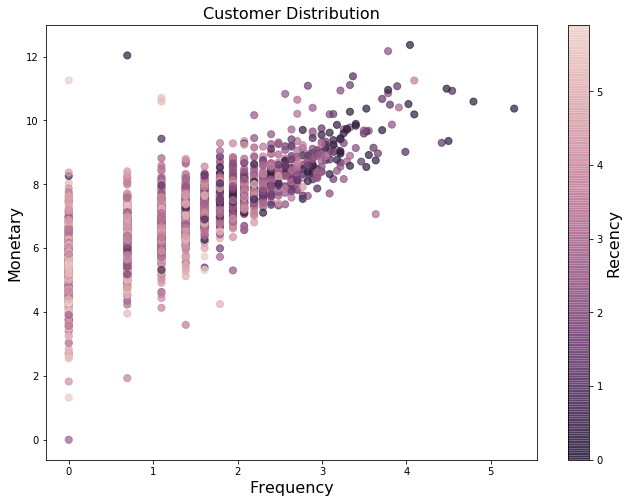

In [84]:
#using original dataset makes the graph not interpretable, so we need to plot trandformed data 
#visaulize the data
fig2=plt.figure(figsize=(11, 8))
cmap = sns.cubehelix_palette(reverse=True,as_cmap=True) #reverse you can change color darkness scale
ax2 = fig2.add_subplot(111)

#for i in range(len(customers.Pareto)):
#plt.scatter(xs[i], ys[i], marker=m[i])
points=ax2.scatter(customers.FrequencyLog,customers.MonetaryLog,c=customers.RecencyLog,s=50, cmap=cmap, alpha=0.7)
   

ax2.set_xlabel('Frequency', fontsize=16)
ax2.set_ylabel('Monetary', fontsize=16)
ax2.set_title('Customer Distribution', fontsize=16)

cbar=fig2.colorbar(points)
#cbar.ax.set_yticklabels('Recency')  #change the scale of colorbar
cbar.ax.set_ylabel('Recency', fontsize=16)

plt.show()


In [85]:
#get rid of outliers

#Count number of True in a col
#np.sum(customers.MonetaryLog<0)
#np.sum(customers.Monetary<0)
#np.sum(customers.MonetaryLog<0)
#np.sum(customers.Monetary==0)


In [86]:
from sklearn.mixture import GMM
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

In [87]:
# Create range of clusters 
range_n_clusters = list(range(2,11))
#print(range_n_clusters)

In [88]:
scaled_data=customers.iloc[:,-3:]

In [89]:
for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters).fit(scaled_data)

    
    preds = clusterer.predict(scaled_data)

    
    centers = clusterer.cluster_centers_    

    
    score = silhouette_score(scaled_data, preds, metric='euclidean')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score)) 
#The silhouette score ranges from −1 to +1, where a high value indicates that the object is well matched to its own 
#cluster and poorly matched to neighboring clusters. 

For n_clusters = 2. The average silhouette_score is : 0.4345118589821195
For n_clusters = 3. The average silhouette_score is : 0.34766234673935603
For n_clusters = 4. The average silhouette_score is : 0.338252118954858
For n_clusters = 5. The average silhouette_score is : 0.3061437819578833
For n_clusters = 6. The average silhouette_score is : 0.31120703472669214
For n_clusters = 7. The average silhouette_score is : 0.30952599793014296
For n_clusters = 8. The average silhouette_score is : 0.3065259881283008
For n_clusters = 9. The average silhouette_score is : 0.288676993431466
For n_clusters = 10. The average silhouette_score is : 0.29109412489124925


In [90]:
score=[]

for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters).fit(scaled_data)
    
    
    preds = clusterer.predict(scaled_data)

    
    centers = clusterer.cluster_centers_   

    
    score.append(silhouette_score(scaled_data, preds, metric='euclidean')) 

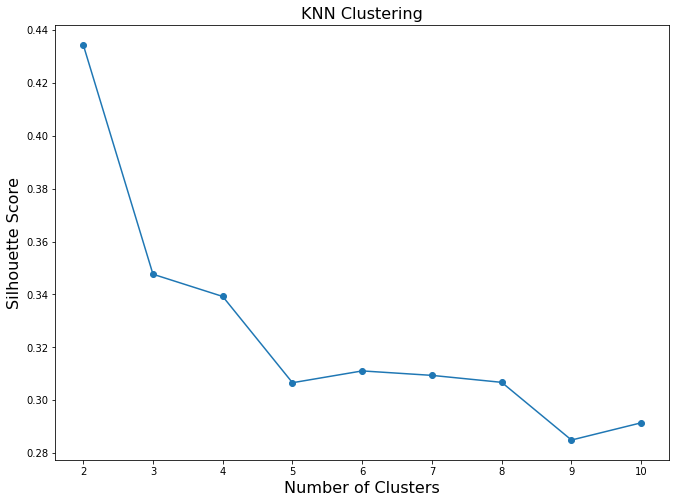

In [91]:
plt.figure(figsize=(11, 8))
plt.plot(range_n_clusters, score, '-o')
plt.title('KNN Clustering', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=16) 
plt.ylabel('Silhouette Score', fontsize=16)
plt.show()

In [92]:
from scipy.spatial.distance import cdist, pdist
#draw elbow plot
def elbow(df, n):
    kMeansVar = [KMeans(n_clusters=k).fit(df.values) for k in range(1, n)]
    centroids = [X.cluster_centers_ for X in kMeansVar]
    k_euclid = [cdist(df.values, cent) for cent in centroids]
    dist = [np.min(ke, axis=1) for ke in k_euclid]
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(df.values)**2)/df.values.shape[0]
    bss = tss - wcss
    percentage=bss/tss
    plt.figure(figsize=(11,8))
    plt.plot(percentage)
    plt.title('Elbow Plot', fontsize=16)
    plt.xlabel('Number of Clusters', fontsize=16)
    plt.ylabel('Percentage of Variance Explained', fontsize=16)
    plt.show()

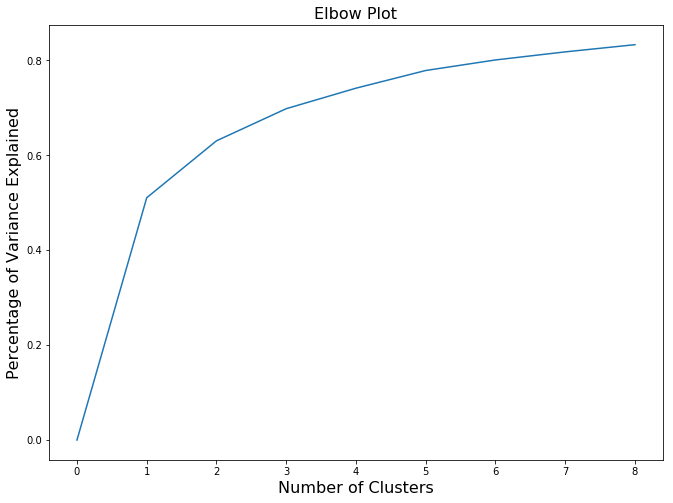

In [93]:
elbow(scaled_data,10)

In [94]:
warnings.filterwarnings('ignore')
for n_clusters in range_n_clusters:
    
    clusterer = GMM(n_components=n_clusters).fit(scaled_data)

    
    preds = clusterer.predict(scaled_data)

    
    centers = clusterer.means_


    
    score = silhouette_score(scaled_data, preds, metric='mahalanobis')
    print ("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.24256152628545602
For n_clusters = 3. The average silhouette_score is : 0.16374381179283287
For n_clusters = 4. The average silhouette_score is : 0.1212373890987913
For n_clusters = 5. The average silhouette_score is : 0.08553022636013029
For n_clusters = 6. The average silhouette_score is : 0.07370772558684893
For n_clusters = 7. The average silhouette_score is : 0.06222005101807922
For n_clusters = 8. The average silhouette_score is : 0.06447084427867796
For n_clusters = 9. The average silhouette_score is : 0.019539740528977407
For n_clusters = 10. The average silhouette_score is : 0.05694448702663805


In [95]:
warnings.filterwarnings('ignore')
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        
        gmm = GMM(n_components=n_components, covariance_type=cv_type)
        gmm.fit(scaled_data)
        bic.append(gmm.bic(scaled_data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

In [96]:
pred=DBSCAN(eps=0.3, min_samples=30).fit_predict(scaled_data)

In [97]:
clusterer2 = KMeans(n_clusters=2).fit(scaled_data)

    
preds2 = clusterer2.predict(scaled_data)

In [98]:
clusterer5 = KMeans(n_clusters=5).fit(scaled_data)

    
preds5 = clusterer5.predict(scaled_data)

In [99]:
customers['Cluster_2']=preds2


In [100]:
customers['Cluster_5']=preds5

In [101]:
customers.head()

,CustomerID,Recency,Frequency,Monetary,Pareto,RecencyLog,FrequencyLog,MonetaryLog,RecencyScale,FrequencyScale,MonetaryScale,Cluster_2,Cluster_5
0,12346,325,1,77183.60,Top 20%,5.783825,0.000000,11.253942,1.425140,-1.042054,3.795425,0,4
1,12747,2,10,3837.45,Top 20%,0.693147,2.302585,8.252563,-2.057858,1.537518,1.383611,0,0
2,12748,0,196,31854.58,Top 20%,0.001000,5.278115,10.368936,-2.531419,4.870985,3.084262,0,0
3,12749,3,5,4090.88,Top 20%,1.098612,1.609438,8.316515,-1.780442,0.760989,1.435001,0,0
4,12820,3,4,942.34,Bottom 80%,1.098612,1.386294,6.848366,-1.780442,0.511003,0.255243,0,2


In [102]:
import sys
sys.path.append('/anaconda3/envs/virtual/lib/python3.6/site-packages')

In [103]:
import plotly
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [104]:
cluster1=customers.loc[customers['Cluster_2'] == 0]
cluster2=customers.loc[customers['Cluster_2'] == 1]
#print(cluster1.head())
#print(cluster2.head())
#print(cluster1.Monetary)

In [105]:
cluster1=customers.loc[customers['Cluster_2'] == 0]
cluster2=customers.loc[customers['Cluster_2'] == 1]

scatter1 = dict(
    mode = "markers",
    name = "Cluster 1",
    type = "scatter3d",    
    x = cluster1.as_matrix()[:,6], y = cluster1.as_matrix()[:,7], z = cluster1.as_matrix()[:,5],
    marker = dict( size=2, color='green')
)
scatter2 = dict(
    mode = "markers",
    name = "Cluster 2",
    type = "scatter3d",    
    x = cluster2.as_matrix()[:,6], y = cluster2.as_matrix()[:,7], z = cluster2.as_matrix()[:,5],
    marker = dict( size=2, color='blue')
)

cluster1 = dict(
    alphahull = 5,
    name = "Cluster 1",
    opacity = .1,
    type = "mesh3d",    
    x = cluster1.as_matrix()[:,6], y = cluster1.as_matrix()[:,7], z = cluster1.as_matrix()[:,5],
    color='green', showscale = True,
)
cluster2 = dict(
    alphahull = 5,
    name = "Cluster 2",
    opacity = .1,
    type = "mesh3d",    
    x = cluster2.as_matrix()[:,6], y = cluster2.as_matrix()[:,7], z = cluster2.as_matrix()[:,5],
    color='blue', showscale = True
)

layout = dict(
    title = 'Customer Distribution with 2 Clusters',
    
    scene = dict(
        xaxis = dict(title='Log Frequency',titlefont=dict(size=20),zeroline=True ),
        yaxis = dict(title='Log Monetary',titlefont=dict(size=20),zeroline=True ),
        zaxis = dict(title='Log Recency', titlefont=dict(size=20),zeroline=True ),
    )
)
fig = dict( data=[scatter1, scatter2, cluster1, cluster2], layout=layout )
# Use py.iplot() for IPython notebook
plotly.offline.iplot(fig, filename='mesh3d_sample')
plot(fig)

'file:///Users/shwetatatiya/Big_Data_Project/temp-plot.html'

In [106]:
#not interactive file 
#fig = plt.figure(figsize=(11, 8))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(customers.FrequencyLog, customers.MonetaryLog, customers.RecencyLog, c=customers.Cluster_2) 
#ax.set_title('Customer Distribution with 2 Clusters', fontsize=16)
#ax.set_xlabel('Log Frequency',fontsize=16)
#ax.set_ylabel('Log Monetary',fontsize=16)
#ax.set_zlabel('Log Recency',fontsize=16)


In [107]:
cluster1=customers.loc[customers['Cluster_5'] == 0]
cluster2=customers.loc[customers['Cluster_5'] == 1]
cluster3=customers.loc[customers['Cluster_5'] == 2]
cluster4=customers.loc[customers['Cluster_5'] == 3]
cluster5=customers.loc[customers['Cluster_5'] == 4]

scatter1 = dict(
    mode = "markers",
    name = "Cluster 1",
    type = "scatter3d",    
    x = cluster1.as_matrix()[:,6], y = cluster1.as_matrix()[:,7], z = cluster1.as_matrix()[:,5],
    marker = dict( size=2, color='green')
)
scatter2 = dict(
    mode = "markers",
    name = "Cluster 2",
    type = "scatter3d",    
    x = cluster2.as_matrix()[:,6], y = cluster2.as_matrix()[:,7], z = cluster2.as_matrix()[:,5],
    marker = dict( size=2, color='blue')
)
scatter3 = dict(
    mode = "markers",
    name = "Cluster 3",
    type = "scatter3d",    
    x = cluster3.as_matrix()[:,6], y = cluster3.as_matrix()[:,7], z = cluster3.as_matrix()[:,5],
    marker = dict( size=2, color='red')
)
scatter4 = dict(
    mode = "markers",
    name = "Cluster 4",
    type = "scatter3d",    
    x = cluster4.as_matrix()[:,6], y = cluster4.as_matrix()[:,7], z = cluster4.as_matrix()[:,5],
    marker = dict( size=2, color='yellow')
)
scatter5 = dict(
    mode = "markers",
    name = "Cluster 5",
    type = "scatter3d",    
    x = cluster5.as_matrix()[:,6], y = cluster5.as_matrix()[:,7], z = cluster5.as_matrix()[:,5],
    marker = dict( size=2, color='black')
)

cluster1 = dict(
    alphahull = 5,
    name = "Cluster 1",
    opacity = .1,
    type = "mesh3d",    
    x = cluster1.as_matrix()[:,6], y = cluster1.as_matrix()[:,7], z = cluster1.as_matrix()[:,5],
    color='green', showscale = True
)
cluster2 = dict(
    alphahull = 5,
    name = "Cluster 2",
    opacity = .1,
    type = "mesh3d",    
    x = cluster2.as_matrix()[:,6], y = cluster2.as_matrix()[:,7], z = cluster2.as_matrix()[:,5],
    color='blue', showscale = True
)
cluster3 = dict(
    alphahull = 5,
    name = "Cluster 3",
    opacity = .1,
    type = "mesh3d",    
    x = cluster3.as_matrix()[:,6], y = cluster3.as_matrix()[:,7], z = cluster3.as_matrix()[:,5],
    color='red', showscale = True
)
cluster4 = dict(
    alphahull = 5,
    name = "Cluster 4",
    opacity = .1,
    type = "mesh3d",    
    x = cluster4.as_matrix()[:,6], y = cluster4.as_matrix()[:,7], z = cluster4.as_matrix()[:,5],
    color='yellow', showscale = True
)
cluster5 = dict(
    alphahull = 5,
    name = "Cluster 5",
    opacity = .1,
    type = "mesh3d",    
    x = cluster5.as_matrix()[:,6], y = cluster5.as_matrix()[:,7], z = cluster5.as_matrix()[:,5],
    color='black', showscale = True
)

layout = dict(
    title = 'Customer Distribution with 5 Clusters',
    
    scene = dict(
        xaxis = dict(title='Log Frequency',titlefont=dict(size=20),zeroline=True ),
        yaxis = dict(title='Log Monetary',titlefont=dict(size=20),zeroline=True ),
        zaxis = dict(title='Log Recency', titlefont=dict(size=20),zeroline=True ),
    )
)
fig = dict( data=[scatter1, scatter2,scatter3,scatter4,scatter5, cluster1, cluster2,cluster3,cluster4,cluster5], layout=layout )
# Use py.iplot() for IPython notebook
plotly.offline.iplot(fig, filename='mesh3d_sample2')
plot(fig)

'file:///Users/shwetatatiya/Big_Data_Project/temp-plot.html'

In [108]:
#fig = plt.figure(figsize=(11, 8))
#ax = fig.add_subplot(111, projection='3d')
#points=ax.scatter(customers.FrequencyLog, customers.MonetaryLog, customers.RecencyLog, c=customers.Cluster_5) 
#ax.set_title('Customer Distribution with 5 Clusters', fontsize=16)
#ax.set_xlabel('Log Frequency',fontsize=16)
#ax.set_ylabel('Log Monetary',fontsize=16)
#ax.set_zlabel('Log Recency',fontsize=16)